# 如何将GPT-4o与RAG结合起来 - 创建一个服装搭配App欢迎来到服装搭配App的Jupyter Notebook！该项目展示了GPT-4o模型在分析服装物品图像并提取关键特征（如颜色、风格和类型）方面的强大能力。我们的应用程序的核心依赖于由OpenAI开发的这一先进图像分析模型，这使我们能够准确识别输入服装物品的特征。GPT-4o是一个结合了自然语言处理和图像识别的模型，使其能够理解并根据文本和视觉输入生成响应。借助GPT-4o模型的能力，我们采用自定义匹配算法和RAG技术来搜索我们的知识库，以寻找与识别特征相辅相成的物品。该算法考虑了颜色兼容性和风格连贯性等因素，为用户提供合适的推荐。通过这个笔记本，我们旨在展示这些技术在创建服装推荐系统方面的实际应用。使用GPT-4o + RAG（检索增强生成）的组合提供了几个优势：1. **情境理解**：GPT-4o可以分析输入图像并理解上下文，如所描绘的对象、场景和活动。这使得在各个领域（无论是室内设计、烹饪还是教育）中提供更准确和相关的建议或信息成为可能。2. **丰富的知识库**：RAG将GPT-4的生成能力与检索组件相结合，访问跨不同领域的大量信息语料库。这意味着系统可以基于广泛的知识范围（从历史事实到科学概念）提供建议或见解。3. **定制化**：这种方法允许轻松定制以满足各种应用中特定用户的需求或偏好。无论是根据用户对艺术的品味量身定制建议，还是根据学生的学习水平提供教育内容，系统都可以被调整以提供个性化体验。总的来说，GPT-4o + RAG方法为各种与时尚相关的应用提供了强大而灵活的解决方案，利用了生成和基于检索的人工智能技术的优势。

### 环境设置

首先我们将安装必要的依赖项，然后导入库并编写一些我们稍后将使用的实用函数。

In [ ]:
%pip install openai --quiet%pip install tenacity --quiet%pip install tqdm --quiet%pip install numpy --quiet%pip install typing --quiet%pip install tiktoken --quiet%pip install concurrent --quiet

In [2]:
import pandas as pdimport numpy as npimport jsonimport astimport tiktokenimport concurrentfrom openai import OpenAIfrom tqdm import tqdmfrom tenacity import retry, wait_random_exponential, stop_after_attemptfrom IPython.display import Image, display, HTMLfrom typing import Listclient = OpenAI()GPT_MODEL = "gpt-4o"EMBEDDING_MODEL = "text-embedding-3-large"EMBEDDING_COST_PER_1K_TOKENS = 0.00013

### 创建嵌入向量现在，我们将通过选择一个数据库并为其生成嵌入向量来设置知识库。我将在data文件夹中使用`sample_styles.csv`文件进行此操作。这是一个包含约`44K`个项目的更大数据集的样本。这一步也可以通过使用现成的向量数据库来替代。例如，您可以按照[这些示例](https://github.com/openai/openai-cookbook/tree/main/examples/vector_databases)之一来设置您的向量数据库。

In [3]:
styles_filepath = "data/sample_clothes/sample_styles.csv"styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')print(styles_df.head())print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt  
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts  
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt  
3  2012.0  Ethnic                  Fabindia Men Blue Kurta  
4  2012.0  Ethnic        Shree Women Multi Colored Patiala  
Opened dataset successfully. Dataset has 1000 items of clothing.


现在我们将为整个数据集生成嵌入。我们可以并行执行这些嵌入操作，以确保脚本能够适用于更大的数据集。根据这种逻辑，为完整的`44K`条数据集创建嵌入的时间从大约4小时减少到大约2-3分钟。

In [4]:
# #批量嵌入逻辑# 简单函数，接收一组文本对象，并返回其对应的嵌入列表。@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(10))def get_embeddings(input: List):    response = client.embeddings.create(        input=input,        model=EMBEDDING_MODEL    ).data    return [data.embedding for data in response]# 将一个可迭代对象拆分为多个大小为 n 的批次。def batchify(iterable, n=1):    l = len(iterable)    for ndx in range(0, l, n):        yield iterable[ndx : min(ndx + n, l)]     # 用于批处理和并行处理嵌入的函数def embed_corpus(    corpus: List[str],    batch_size=64,    num_workers=8,    max_context_len=8191,):    # 对语料库进行编码，截断至最大上下文长度    encoding = tiktoken.get_encoding("cl100k_base")    encoded_corpus = [        encoded_article[:max_context_len] for encoded_article in encoding.encode_batch(corpus)    ]    # 计算语料库统计数据：输入数量、总词元数以及嵌入的预估成本    num_tokens = sum(len(article) for article in encoded_corpus)    cost_to_embed_tokens = num_tokens / 1000 * EMBEDDING_COST_PER_1K_TOKENS    print(        f"num_articles={len(encoded_corpus)}, num_tokens={num_tokens}, est_embedding_cost={cost_to_embed_tokens:.2f} USD"    )    # 嵌入语料库    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:                futures = [            executor.submit(get_embeddings, text_batch)            for text_batch in batchify(encoded_corpus, batch_size)        ]        with tqdm(total=len(encoded_corpus)) as pbar:            for _ in concurrent.futures.as_completed(futures):                pbar.update(batch_size)        embeddings = []        for future in futures:            data = future.result()            embeddings.extend(data)        return embeddings    # 用于生成DataFrame中指定列嵌入的函数def generate_embeddings(df, column_name):    # 初始化一个空列表以存储嵌入    descriptions = df[column_name].astype(str).tolist()    embeddings = embed_corpus(descriptions)    # 将嵌入向量作为新列添加到 DataFrame 中    df['embeddings'] = embeddings    print("Embeddings created successfully.")

#### 创建嵌入向量的两种选项：下一行将为样本服装数据集**创建嵌入向量**。这个过程大约需要0.02秒来处理，另外约30秒来将结果写入本地的 .csv 文件。该过程使用我们的 `text_embedding_3_large` 模型，价格为 `$0.00013/1K` 个标记。考虑到数据集大约有 `1K` 条目，以下操作的成本大约为 `$0.001`。如果您决定使用完整的 `44K` 条目数据集，这个操作将需要2-3分钟来处理，成本大约为 `$0.07`。**如果您不想继续创建自己的嵌入向量**，我们将使用预先计算的嵌入向量数据集。您可以跳过此单元格，并取消注释下一个单元格中的代码以继续加载预先计算的向量。这个操作需要大约1分钟来将所有数据加载到内存中。

In [5]:
generate_embeddings(styles_df, 'productDisplayName')print("Writing embeddings to file ...")styles_df.to_csv('data/sample_clothes/sample_styles_with_embeddings.csv', index=False)print("Embeddings successfully stored in sample_styles_with_embeddings.csv")

num_articles=1000, num_tokens=8280, est_embedding_cost=0.00 USD


1024it [00:01, 724.12it/s]                         


Embeddings created successfully.
Writing embeddings to file ...
Embeddings successfully stored in sample_styles_with_embeddings.csv


In [6]:
# styles_df = pd.read_csv('data/sample_clothes/sample_styles_with_embeddings.csv', on_bad_lines='skip')# # Convert the 'embeddings' column from string representations of lists to actual lists of floats# styles_df['embeddings'] = styles_df['embeddings'].apply(lambda x: ast.literal_eval(x))print(styles_df.head())print("Opened dataset successfully. Dataset has {} items of clothing along with their embeddings.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  \
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt   
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts   
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt   
3  2012.0  Ethnic                  Fabindia Men Blue Kurta   
4  2012.0  Ethnic        Shree Women Multi Colored Patiala   

                                          embeddings  
0  [0.006903026718646288, 0.0004031236458104104, ...  
1  [-0.04371623694896698, -0.008869604207575321, ...  

### 构建匹配算法在本节中，我们将开发一个余弦相似度检索算法，以在我们的数据框中找到相似的项目。我们将利用我们自定义的余弦相似度函数来实现这一目的。虽然`sklearn`库提供了一个内置的余弦相似度函数，但其SDK的最近更新导致了兼容性问题，促使我们实现我们自己的标准余弦相似度计算。如果您已经设置了一个向量数据库，您可以跳过这一步。大多数标准数据库都配备了自己的搜索功能，这简化了本指南中概述的后续步骤。然而，我们的目标是演示匹配算法可以根据特定要求进行定制，比如特定阈值或指定返回的匹配数量。`find_similar_items`函数接受四个参数：- `embedding`：我们想要找到匹配项的嵌入。- `embeddings`：要搜索以找到最佳匹配项的嵌入列表。- `threshold`（可选）：此参数指定要考虑为有效匹配的最小相似度分数。较高的阈值会产生更接近（更好）的匹配，而较低的阈值允许返回更多的项目，尽管它们可能与初始的`embedding`不太匹配。- `top_k`（可选）：此参数确定要返回的超过给定阈值的项目数量。这些将是提供的`embedding`的得分最高的匹配项。

In [7]:
def cosine_similarity_manual(vec1, vec2):    """计算两个向量之间的余弦相似度。"""    vec1 = np.array(vec1, dtype=float)    vec2 = np.array(vec2, dtype=float)    dot_product = np.dot(vec1, vec2)    norm_vec1 = np.linalg.norm(vec1)    norm_vec2 = np.linalg.norm(vec2)    return dot_product / (norm_vec1 * norm_vec2)def find_similar_items(input_embedding, embeddings, threshold=0.5, top_k=2):    """根据余弦相似度，找出最相似的条目。"""        # 计算输入嵌入与所有其他嵌入之间的余弦相似度    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]        # 过滤掉低于阈值的相似之处    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]        # 将筛选出的相似度按相似度分数进行排序    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]    # 返回最相似的前k个项目    return sorted_indices

In [8]:
def find_matching_items_with_rag(df_items, item_descs):   """根据输入的物品描述，为每个描述找到基于余弦相似度的最相似物品。"""      # 从DataFrame中选择嵌入。   embeddings = df_items['embeddings'].tolist()      similar_items = []   for desc in item_descs:            # 生成输入项的嵌入表示      input_embedding = get_embeddings([desc])          # 根据余弦相似度寻找最相似的条目      similar_indices = find_similar_items(input_embedding, embeddings, threshold=0.6)      similar_items += [df_items.iloc[i] for i in similar_indices]       return similar_items

### 分析模块在这个模块中，我们利用 `gpt-4o` 来分析输入的图像，并提取重要特征，如详细描述、风格和类型。分析是通过一个简单的 API 调用来执行的，我们提供图像的 URL 进行分析，并请求模型识别相关特征。为了确保模型返回准确的结果，我们在提示中使用了特定的技术：1. **输出格式规范**：我们指示模型返回一个具有预定义结构的 JSON 块，包括：   - `items` (str[]): 一个字符串列表，每个字符串代表服装项目的简洁标题，包括风格、颜色和性别。这些标题与我们原始数据库中的 `productDisplayName` 属性非常相似。   - `category` (str): 最能代表给定项目的类别。模型从原始样式数据框中存在的所有唯一 `articleTypes` 列表中进行选择。   - `gender` (str): 表示项目面向的性别的标签。模型从选项 `[Men, Women, Boys, Girls, Unisex]` 中选择。2. **清晰简明的说明**：   - 我们提供清晰的说明，说明项目标题应包含什么以及输出格式应该是什么样的。输出应该是 JSON 格式，但不包含模型响应通常包含的 `json` 标签。3. **一次性示例**：   - 为了进一步澄清预期的输出，我们向模型提供一个示例输入描述和相应的示例输出。虽然这可能会增加使用的标记数（从而增加调用的成本），但它有助于指导模型，从而获得更好的整体性能。通过遵循这种结构化方法，我们的目标是从 `gpt-4o` 模型中获取精确和有用的信息，以便进一步分析并集成到我们的数据库中。

In [9]:
def analyze_image(image_base64, subcategories):    response = client.chat.completions.create(        model=GPT_MODEL,        messages=[            {            "role": "user",            "content": [                {                "type": "text",                "text": """Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender".                            Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.                           The items field should be a list of items that would go well with the item in the picture. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.                           The category needs to be chosen between the types in this list: {subcategories}.                           You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]                           Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.                                                      Example Input: An image representing a black leather jacket.                           Example Output: {"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}                           """,                },                {                "type": "image_url",                "image_url": {                    "url": f"data:image/jpeg;base64,{image_base64}",                },                }            ],            }        ],        max_tokens=300,    )    # 从响应中提取相关特征    features = response.choices[0].message.content    return features

### 使用示例图片测试提示为了评估我们的提示的有效性，让我们加载并使用数据集中的一组图片来测试它。我们将使用位于`"data/sample_clothes/sample_images"`文件夹中的图片，确保涵盖各种风格、性别和类型。以下是所选样本：- `2133.jpg`：男士衬衫- `7143.jpg`：女士衬衫- `4226.jpg`：休闲男士印花T恤通过使用这些不同的图片来测试提示，我们可以评估其准确分析和提取不同类型服装和配饰的相关特征的能力。

我们需要一个实用函数来将.jpg图像编码为base64。

In [10]:
import base64def encode_image_to_base64(image_path):    with open(image_path, 'rb') as image_file:        encoded_image = base64.b64encode(image_file.read())        return encoded_image.decode('utf-8')

In [11]:
# 设置图像路径并选择一张测试图像image_path = "data/sample_clothes/sample_images/"test_images = ["2133.jpg", "7143.jpg", "4226.jpg"]# 将测试图像编码为Base64格式。reference_image = image_path + test_images[0]encoded_image = encode_image_to_base64(reference_image)

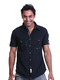

{'items': ["Slim Fit Blue Men's Jeans", "White Men's Sneakers", "Men's Silver Watch"], 'category': 'Shirts', 'gender': 'Men'}


In [12]:
# 从DataFrame中选择唯一的子类别unique_subcategories = styles_df['articleType'].unique()# 分析图像并返回结果analysis = analyze_image(encoded_image, unique_subcategories)image_analysis = json.loads(analysis)# 显示图像及分析结果display(Image(filename=reference_image))print(image_analysis)

接下来，我们处理图像分析的输出，并将其用于过滤和显示与我们的数据集匹配的物品。以下是代码的详细说明：1. **提取图像分析结果**：我们从`image_analysis`字典中提取物品描述、类别和性别。2. **过滤数据集**：我们将`styles_df` DataFrame进行过滤，只包括与图像分析中的性别匹配（或是中性的）并排除与分析图像相同类别的物品。3. **查找匹配的物品**：我们使用`find_matching_items_with_rag`函数在过滤后的数据集中查找与从分析图像中提取的描述相匹配的物品。4. **显示匹配的物品**：我们创建一个HTML字符串来显示匹配物品的图像。我们使用物品ID构建图像路径，并将每个图像附加到HTML字符串中。最后，我们使用`display(HTML(html))`在笔记本中呈现这些图像。这个单元格有效地演示了如何使用图像分析的结果来过滤数据集，并直观地显示与分析图像特征匹配的物品。

In [13]:
# 从分析中提取相关特征item_descs = image_analysis['items']item_category = image_analysis['category']item_gender = image_analysis['gender']# 过滤数据，以便我们只浏览同一性别（或中性）且不同类别的商品。filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]filtered_items = filtered_items[filtered_items['articleType'] != item_category]print(str(len(filtered_items)) + " Remaining Items")# 根据输入的物品描述，寻找最相似的物品。matching_items = find_matching_items_with_rag(filtered_items, item_descs)# 显示匹配项（这将显示图像分析中每个描述的2个项目）html = ""paths = []for i, item in enumerate(matching_items):    item_id = item['id']            # 图片文件路径    image_path = f'data/sample_clothes/sample_images/{item_id}.jpg'    paths.append(image_path)    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'# 打印出匹配的物品描述，作为我们寻找目标的提示。print(item_descs)# 显示图像display(HTML(html))

513 Remaining Items
["Slim Fit Blue Men's Jeans", "White Men's Sneakers", "Men's Silver Watch"]


### 安全防护在使用大型语言模型（LLMs）如GPT-4o时，“安全防护”指的是为确保模型的输出保持在期望的参数或边界内而设置的机制或检查。这些安全防护对于维护模型响应的质量和相关性至关重要，特别是在处理复杂或微妙的任务时。安全防护有几个重要作用：1. **准确性**：它们有助于确保模型的输出准确且与提供的输入相关。2. **一致性**：在处理相似或相关的输入时，它们保持模型响应的一致性。3. **安全性**：它们防止模型生成有害、冒犯或不适当的内容。4. **上下文相关性**：它们确保模型的输出与特定任务或领域的上下文相关。在我们的案例中，我们正在使用GPT-4o来分析时尚图片并建议与原始服装相配的物品。为了实施安全防护，我们可以**优化结果**：在从GPT-4o获得初始建议后，我们可以将原始图片和建议的物品发送回模型。然后，我们可以要求GPT-4o评估每个建议的物品是否确实适合原始服装。这使模型能够根据反馈或额外信息进行自我纠正和调整其输出。通过实施这些安全防护并启用自我纠正，我们可以增强模型在时尚分析和推荐领域的输出的可靠性和实用性。为了实现这一点，我们编写一个提示，要求LLM对于建议的物品是否与原始服装相匹配给出简单的“是”或“否”答案。这种二元响应有助于简化优化过程，并确保模型提供清晰且可操作的反馈。

In [14]:
def check_match(reference_image_base64, suggested_image_base64):    response = client.chat.completions.create(        model=GPT_MODEL,        messages=[            {            "role": "user",            "content": [                {                "type": "text",                "text": """ You will be given two images of two different items of clothing.                            Your goal is to decide if the items in the images would work in an outfit together.                            The first image is the reference item (the item that the user is trying to match with another item).                            You need to decide if the second item would work well with the reference item.                            Your response must be a JSON output with the following fields: "answer", "reason".                            The "answer" field must be either "yes" or "no", depending on whether you think the items would work well together.                            The "reason" field must be a short explanation of your reasoning for your decision. Do not include the descriptions of the 2 images.                            Do not include the ```json ``` tag in the output.                           """,                },                {                "type": "image_url",                "image_url": {                    "url": f"data:image/jpeg;base64,{reference_image_base64}",                },                },                {                "type": "image_url",                "image_url": {                    "url": f"data:image/jpeg;base64,{suggested_image_base64}",                },                }            ],            }        ],        max_tokens=300,    )    # 从响应中提取相关特征    features = response.choices[0].message.content    return features

最后，让我们确定上面识别出的哪些物品真正搭配这套服装。

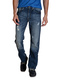

The items match!
The black shirt and blue jeans create a classic and casual outfit that works well together.


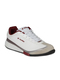

The items match!
The black shirt and the white sneakers with red and beige accents can work well together. Black is a versatile color that pairs well with many shoe options, and the white sneakers can add a sporty and casual touch to the outfit.


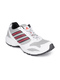

The items match!
The black button-up shirt is casual and versatile, making it compatible with the white and red athletic shoes for a relaxed and sporty look.


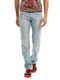

The items match!
The black shirt pairs well with the light blue jeans, creating a classic and balanced color combination that is casual and stylish.


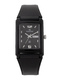

The items match!
Both the black shirt and the black watch have a sleek and coordinated look, making them suitable to be worn together as part of an outfit.


In [15]:
# 选择生成图像的独特路径paths = list(set(paths))for path in paths:    # 将测试图像编码为Base64格式。    suggested_image = encode_image_to_base64(path)        # 检查物品是否匹配    match = json.loads(check_match(encoded_image, suggested_image))        # 显示图像及分析结果    if match["answer"] == 'yes':        display(Image(filename=path))        print("The items match!")        print(match["reason"])

我们可以观察到潜在物品的初始列表已经进一步精选，形成了一个更加精心挑选的选择，与服装很好地匹配。此外，模型还提供了每个物品被认为是一个好匹配的解释，为决策过程提供了宝贵的见解。

### 结论在这个Jupyter Notebook中，我们探讨了GPT-4o和其他机器学习技术在时尚领域的应用。我们演示了如何分析服装物品的图像，提取相关特征，并利用这些信息找到与原始服装搭配的物品。通过实施防护栏和自我校正机制，我们优化了模型的建议，以确保它们准确且与上下文相关。这种方法在现实世界中有几个实际用途，包括：1. **个性化购物助手**：零售商可以利用这项技术为客户提供个性化的服装推荐，增强购物体验，提高客户满意度。2. **虚拟衣橱应用**：用户可以上传他们自己服装物品的图像，创建虚拟衣橱，并获得与其现有服装相匹配的新物品建议。3. **时尚设计和造型**：时尚设计师和造型师可以利用这个工具尝试不同的组合和风格，简化创意过程。然而，需要考虑的一个因素是**成本**。LLMs和图像分析模型的使用可能会带来成本，特别是在大量使用时。重要的是要考虑实施这些技术的成本效益。总的来说，这个笔记本为时尚和人工智能交叉领域的进一步探索和发展奠定了基础，为更个性化和智能的时尚推荐系统打开了大门。